In [1]:
# General imports
import numpy as np
import sys, os
basepath = "../"
sys.path.insert(0, basepath)
import utils.plotting_utils as plots

In [2]:
#  Load the 5BZCat catalog
from lib.data import load_5bzcat, catbins, load_hotspots

cat = load_5bzcat(os.path.join(basepath, "data"))

# Load the hotspot list
hotspot_folder = "data/7yrPS_data"
hemi = "north"
hotspots = load_hotspots(os.path.join(basepath, hotspot_folder), hemisphere=hemi)

Load 5bzcat.csv
	Found 3469 sources


In [3]:
# Import stuff for the correlation analysis
from lib.correlation import Correlator, EventSample

In [5]:
# Initialize the Correlator object and the sample of hotspots to analyse.
# Note that catbins is useless for our analysis but the framework still requires it.
# scramble=0 will generate the pseudo experiment by scrambling the position of the sources only.
# boots=6 will generate the trial taking care of preserving the number of source,
# the portion of the sky and the galactic plane cut.
seed = 0
C = Correlator(
    cat, bins=catbins[-1],
    seed=seed,
    dec_range=(np.radians(-5),np.radians(85)),
    mlat=np.radians(10),
    scramble=0, boots=6)
hs_sample = EventSample(hotspots)

sigmas = np.linspace(0.2, 0.65, 10)
pVal_thrs = np.linspace(3.5, 4.5, 3)
C.add_primary('hotspots', hs_sample, logpVal_thr_list=pVal_thrs, sigma_list=sigmas)


# The max_shift argument scrambles the sources within a maximum distance
# from the original position.
# Running 10000 trials takes ~ 5 minutes.
trials = C.trials(n_trials=5000, max_shift=np.radians(10))

- Setting galactic plane width to 0.2deg.
Set scrambling to catalogue
Catalogue: 3469 sources
Applying cuts to the source catalogue:
	Sources in declination range: [-5. 85.] degrees: 2251.
	Applying galactic plane cut...
	After galactic plane cut: 2191
	2191 sources above 0.00 (1.00%)
Remove sources that are in no bin: 0.00%
Analysis - Initialize with seed 0
Applying cuts to the event sample:
	Events in [-5. 85.] degrees: 818
	Applying galactic plane cut...
	After galactic plane cut: 689
	Applying the pValue threshold cuts...
-log10(pVal) > 3.5: 43 hotspots will be analysed.
-log10(pVal) > 4.0: 18 hotspots will be analysed.
-log10(pVal) > 4.5: 7 hotspots will be analysed.
-- Calling function trials of <lib.correlation.Correlator object at 0x10c4b2350>


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 5000 out of 5000 | elapsed:  3.4min finished


--> Time (<lib.correlation.Correlator object at 0x10c4b2350>, trials):  0d  0: 3:26.68


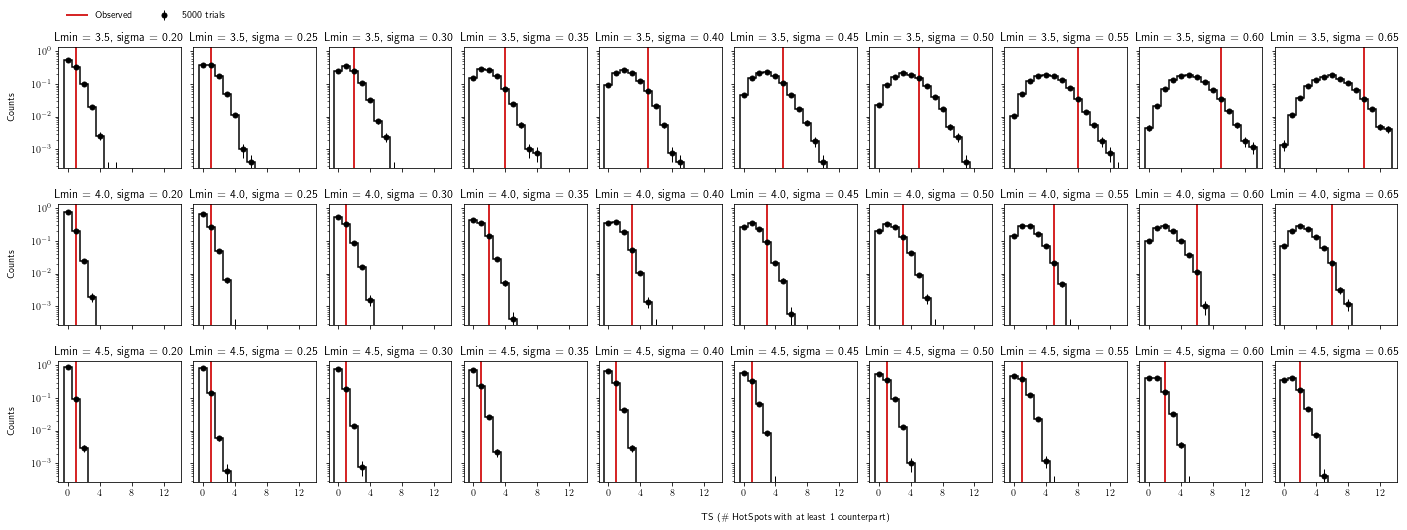

In [7]:
fig,ax = plt.subplots(nrows=pVal_thrs.size, ncols=sigmas.size,
                      sharex=True, sharey=True, figsize=(24,8))

ax[pVal_thrs.size-1][int(sigmas.size/2)].set_xlabel("TS (\# HotSpots with at least 1 counterpart)", labelpad=15)
for axis in ax[:,0]:
    axis.set_ylabel("Counts", labelpad=15)

ax = ax.flatten()
for i,key in enumerate(trials.dtype.names):
    observed_ts = C()[key]
    counts, bins = np.histogram(trials[key], bins=np.arange(0,15))
    binc = 0.5 * (bins[1:] + bins[:-1])-.5
    counts_norm = counts/np.sum(counts)
    ax[i].errorbar(binc, counts_norm, yerr=[np.sqrt(counts)/np.sum(counts),np.sqrt(counts)/np.sum(counts)],
                 fmt="o", color="k", zorder=10, markersize=5, elinewidth=1,
                 label=f"{trials[key].size} trials"
                )
    ax[i].hist(binc, bins-.5, weights=counts_norm, histtype='step', color='k', lw=1.5)
    ax[i].axvline(observed_ts, color="tab:red", label="Observed", lw=2)

    ax[i].set_yscale('log')

    ax[i].set_title(key[10:], fontsize=12)

ax[0].set_xticks([0,4,8,12])
# ax[0].set_xticks([0,1,2,3])
ax[0].legend(frameon=False, loc="lower left", bbox_to_anchor=(0., 1.15), ncol=2)

plt.subplots_adjust(hspace=0.3, wspace=.1)

plt.savefig(f"../plots/ts_distributions_{hemi}.png",
           dpi=500, bbox_inches="tight", facecolor="w")

In [8]:
res, m_cp = C.get_counterparts(catbins[-1])


hotspots: Lmin = 3.5, sigma = 0.20: 1/43 counterparts above [0]
	R.A.[deg]  -  Dec.[deg]  -  HS logpVal  -  Source Name  -  Offset[deg]  -  Redshift
	182.64        39.35         4.66          5BZBJ1210+3929   0.13            0.62       

hotspots: Lmin = 3.5, sigma = 0.25: 1/43 counterparts above [0]
	R.A.[deg]  -  Dec.[deg]  -  HS logpVal  -  Source Name  -  Offset[deg]  -  Redshift
	182.64        39.35         4.66          5BZBJ1210+3929   0.13            0.62       

hotspots: Lmin = 3.5, sigma = 0.30: 2/43 counterparts above [0]
	R.A.[deg]  -  Dec.[deg]  -  HS logpVal  -  Source Name  -  Offset[deg]  -  Redshift
	349.63        16.26         3.66          5BZBJ2319+1611   0.30            nan        
	182.64        39.35         4.66          5BZBJ1210+3929   0.13            0.62       

hotspots: Lmin = 3.5, sigma = 0.35: 4/43 counterparts above [0]
	R.A.[deg]  -  Dec.[deg]  -  HS logpVal  -  Source Name  -  Offset[deg]  -  Redshift
	121.86        50.09         3.54          5BZQJ